In [1]:
import torch,random,pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,random_split,Dataset
from sklearn.metrics import precision_recall_fscore_support
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

/home/aminul/anaconda3/envs/torch_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('/home/aminul/malaria/dataset/segmented_datav3.pkl', "rb") as fp:   # Unpickling
    x1,x2,y1,y2 = pickle.load(fp)

In [3]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    ]) 
class NewDataset(Dataset):
    
    def __init__(self,data,labels,transform=None):
        self.data = data
        self.label = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)    
    def __getitem__(self,idx):
        image = self.data[idx]
        label = self.label[idx]
        return self.transform(image), label

In [4]:
#same test set as the DNN ones.
with open('dataset/anomaly_test_3.pkl', "rb") as fp:   # Unpickling
    test_x,test_y = pickle.load(fp)
    
final_test = NewDataset(test_x,test_y,transform_train)
final_test_loader = DataLoader(final_test, batch_size=1, shuffle=True)

In [5]:
new_trainset = NewDataset(x2,y2,transform_train)
lengths = [int(len(new_trainset)*0.5), int(len(new_trainset)*0.5)]
print(lengths)
main_trainset,hold_testset = random_split(new_trainset,lengths)

lengths = [int(len(main_trainset)*0.8), int(len(main_trainset)*0.2)+1]
print(lengths)
trainset,testset = random_split(main_trainset,lengths)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


[2009, 2009]
[1607, 402]


In [6]:
p_trainset = NewDataset(x1,y1,transform_train)
lengths = [int(len(p_trainset)*0.75), int(len(p_trainset)*0.25)]
print(lengths)
p_trainset,p_testset = random_split(p_trainset,lengths)

p_train_loader = DataLoader(p_trainset, batch_size=32, shuffle=True)
p_test_loader = DataLoader(p_testset, batch_size=32, shuffle=True)

[6000, 2000]


In [7]:
merged_set = torch.utils.data.ConcatDataset([p_testset, hold_testset])
merged_loader = DataLoader(merged_set, batch_size=1, shuffle=True)
#dataiter = iter(merged_loader)
#images, labels = dataiter.next()

#labels

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1,4,3, padding = 1) #input channel, output channel, kernel size
        self.conv2 = nn.Conv2d(4,16,3, padding = 1)
        self.conv3 = nn.Conv2d(16,32,3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)

        self.t_conv1 = nn.ConvTranspose2d(32,16,2,stride = 2)
        self.t_conv2 = nn.ConvTranspose2d(16,4,2,stride = 2)
        self.t_conv3 = nn.ConvTranspose2d(4,1,2,stride = 2)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))

        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.01)

In [10]:
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 4, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(4, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [11]:
def train(model,train_set,criterion,optim,epochs):
    model.train()
    train_loss = 0

    for i,(images, labels) in enumerate(tqdm(train_set)):
        images, labels = images.to(device), labels.to(device)
        optim.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, images.float())
        loss.backward()
        optim.step()

        train_loss += loss.item()


    print("Epoch: [{}]  Train_loss: [{:.4f}]".format(epochs+1,train_loss/len(train_set)))
    return train_loss/len(train_set)

def test(model,test_set, criterion,optim, epochs):
    model.eval()
    test_loss = 0
    for i,(images,labels) in enumerate(tqdm(test_set)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.float())
        loss = criterion(outputs,images.float())

        test_loss += loss.item()

    print("Epoch: [{}]  Test_loss: [{:.4f}]".format(epochs+1,test_loss/len(test_set)))
    return test_loss/len(test_set)


In [12]:
n_epochs = 100
train_loss,test_loss = [],[]

for i in range(n_epochs):
    a = train(model, train_loader, criterion, optim, i)
    b = test(model, test_loader, criterion, optim, i)
    train_loss.append(a), test_loss.append(b)


  0%|                                                                                            | 0/51 [00:00<?, ?it/s]/home/aminul/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.84it/s]


Epoch: [1]  Train_loss: [0.2006]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 189.17it/s]


Epoch: [1]  Test_loss: [0.1349]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 81.21it/s]


Epoch: [2]  Train_loss: [0.1019]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 159.64it/s]


Epoch: [2]  Test_loss: [0.0762]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 66.71it/s]


Epoch: [3]  Train_loss: [0.0649]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 167.12it/s]


Epoch: [3]  Test_loss: [0.0573]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.15it/s]


Epoch: [4]  Train_loss: [0.0512]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 176.62it/s]


Epoch: [4]  Test_loss: [0.0463]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 82.42it/s]


Epoch: [5]  Train_loss: [0.0428]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 155.10it/s]


Epoch: [5]  Test_loss: [0.0395]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.59it/s]


Epoch: [6]  Train_loss: [0.0368]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 191.17it/s]


Epoch: [6]  Test_loss: [0.0358]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.26it/s]


Epoch: [7]  Train_loss: [0.0335]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 185.29it/s]


Epoch: [7]  Test_loss: [0.0335]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.21it/s]


Epoch: [8]  Train_loss: [0.0309]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 179.94it/s]


Epoch: [8]  Test_loss: [0.0318]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.86it/s]


Epoch: [9]  Train_loss: [0.0294]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 178.31it/s]


Epoch: [9]  Test_loss: [0.0285]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.72it/s]


Epoch: [10]  Train_loss: [0.0277]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 189.90it/s]


Epoch: [10]  Test_loss: [0.0277]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.08it/s]


Epoch: [11]  Train_loss: [0.0266]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 177.47it/s]


Epoch: [11]  Test_loss: [0.0267]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.92it/s]


Epoch: [12]  Train_loss: [0.0257]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.34it/s]


Epoch: [12]  Test_loss: [0.0262]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.60it/s]


Epoch: [13]  Train_loss: [0.0252]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 201.49it/s]


Epoch: [13]  Test_loss: [0.0256]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.81it/s]


Epoch: [14]  Train_loss: [0.0244]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 163.99it/s]


Epoch: [14]  Test_loss: [0.0245]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.75it/s]


Epoch: [15]  Train_loss: [0.0238]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 161.09it/s]


Epoch: [15]  Test_loss: [0.0244]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.44it/s]


Epoch: [16]  Train_loss: [0.0233]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 187.45it/s]


Epoch: [16]  Test_loss: [0.0233]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.70it/s]


Epoch: [17]  Train_loss: [0.0228]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 202.79it/s]


Epoch: [17]  Test_loss: [0.0232]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.34it/s]


Epoch: [18]  Train_loss: [0.0225]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 212.92it/s]


Epoch: [18]  Test_loss: [0.0247]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.16it/s]


Epoch: [19]  Train_loss: [0.0226]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 199.66it/s]


Epoch: [19]  Test_loss: [0.0226]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.70it/s]


Epoch: [20]  Train_loss: [0.0220]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 186.58it/s]


Epoch: [20]  Test_loss: [0.0222]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.40it/s]


Epoch: [21]  Train_loss: [0.0219]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 185.12it/s]


Epoch: [21]  Test_loss: [0.0229]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.51it/s]


Epoch: [22]  Train_loss: [0.0216]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.72it/s]


Epoch: [22]  Test_loss: [0.0237]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.64it/s]


Epoch: [23]  Train_loss: [0.0213]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 168.75it/s]


Epoch: [23]  Test_loss: [0.0217]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.82it/s]


Epoch: [24]  Train_loss: [0.0215]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 178.96it/s]


Epoch: [24]  Test_loss: [0.0226]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.61it/s]


Epoch: [25]  Train_loss: [0.0209]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 200.15it/s]


Epoch: [25]  Test_loss: [0.0213]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.66it/s]


Epoch: [26]  Train_loss: [0.0207]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 198.02it/s]


Epoch: [26]  Test_loss: [0.0217]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.81it/s]


Epoch: [27]  Train_loss: [0.0206]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 184.56it/s]


Epoch: [27]  Test_loss: [0.0213]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.53it/s]


Epoch: [28]  Train_loss: [0.0204]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 170.71it/s]


Epoch: [28]  Test_loss: [0.0213]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.07it/s]


Epoch: [29]  Train_loss: [0.0202]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 176.61it/s]


Epoch: [29]  Test_loss: [0.0207]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.88it/s]


Epoch: [30]  Train_loss: [0.0201]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 173.14it/s]


Epoch: [30]  Test_loss: [0.0205]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.05it/s]


Epoch: [31]  Train_loss: [0.0199]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 162.59it/s]


Epoch: [31]  Test_loss: [0.0215]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.49it/s]


Epoch: [32]  Train_loss: [0.0199]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 180.08it/s]


Epoch: [32]  Test_loss: [0.0202]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.09it/s]


Epoch: [33]  Train_loss: [0.0199]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 175.36it/s]


Epoch: [33]  Test_loss: [0.0200]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.02it/s]


Epoch: [34]  Train_loss: [0.0197]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 189.17it/s]


Epoch: [34]  Test_loss: [0.0208]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 72.04it/s]


Epoch: [35]  Train_loss: [0.0195]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 196.21it/s]


Epoch: [35]  Test_loss: [0.0205]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.09it/s]


Epoch: [36]  Train_loss: [0.0194]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 195.63it/s]


Epoch: [36]  Test_loss: [0.0198]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 82.36it/s]


Epoch: [37]  Train_loss: [0.0194]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 179.93it/s]


Epoch: [37]  Test_loss: [0.0203]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.68it/s]


Epoch: [38]  Train_loss: [0.0191]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 202.65it/s]


Epoch: [38]  Test_loss: [0.0199]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.35it/s]


Epoch: [39]  Train_loss: [0.0191]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 195.15it/s]


Epoch: [39]  Test_loss: [0.0193]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.72it/s]


Epoch: [40]  Train_loss: [0.0190]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 179.28it/s]


Epoch: [40]  Test_loss: [0.0207]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.85it/s]


Epoch: [41]  Train_loss: [0.0189]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 182.25it/s]


Epoch: [41]  Test_loss: [0.0201]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.51it/s]


Epoch: [42]  Train_loss: [0.0187]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 217.74it/s]


Epoch: [42]  Test_loss: [0.0195]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.56it/s]


Epoch: [43]  Train_loss: [0.0187]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 202.38it/s]


Epoch: [43]  Test_loss: [0.0194]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.59it/s]


Epoch: [44]  Train_loss: [0.0184]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 202.99it/s]


Epoch: [44]  Test_loss: [0.0196]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.34it/s]


Epoch: [45]  Train_loss: [0.0182]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 201.69it/s]


Epoch: [45]  Test_loss: [0.0192]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.61it/s]


Epoch: [46]  Train_loss: [0.0185]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.20it/s]


Epoch: [46]  Test_loss: [0.0194]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.73it/s]


Epoch: [47]  Train_loss: [0.0182]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 185.93it/s]


Epoch: [47]  Test_loss: [0.0191]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 81.43it/s]


Epoch: [48]  Train_loss: [0.0183]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 180.71it/s]


Epoch: [48]  Test_loss: [0.0187]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.47it/s]


Epoch: [49]  Train_loss: [0.0183]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 210.22it/s]


Epoch: [49]  Test_loss: [0.0185]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 71.49it/s]


Epoch: [50]  Train_loss: [0.0178]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 197.51it/s]


Epoch: [50]  Test_loss: [0.0188]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.87it/s]


Epoch: [51]  Train_loss: [0.0180]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 186.01it/s]


Epoch: [51]  Test_loss: [0.0189]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.40it/s]


Epoch: [52]  Train_loss: [0.0179]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 179.78it/s]


Epoch: [52]  Test_loss: [0.0194]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.02it/s]


Epoch: [53]  Train_loss: [0.0177]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 168.88it/s]


Epoch: [53]  Test_loss: [0.0190]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.68it/s]


Epoch: [54]  Train_loss: [0.0177]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 170.62it/s]


Epoch: [54]  Test_loss: [0.0189]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.89it/s]


Epoch: [55]  Train_loss: [0.0176]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 201.50it/s]


Epoch: [55]  Test_loss: [0.0184]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.79it/s]


Epoch: [56]  Train_loss: [0.0175]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 180.24it/s]


Epoch: [56]  Test_loss: [0.0181]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 81.62it/s]


Epoch: [57]  Train_loss: [0.0173]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 191.59it/s]


Epoch: [57]  Test_loss: [0.0185]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 71.42it/s]


Epoch: [58]  Train_loss: [0.0172]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 190.66it/s]


Epoch: [58]  Test_loss: [0.0179]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.73it/s]


Epoch: [59]  Train_loss: [0.0172]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 178.75it/s]


Epoch: [59]  Test_loss: [0.0190]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.21it/s]


Epoch: [60]  Train_loss: [0.0174]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 196.27it/s]


Epoch: [60]  Test_loss: [0.0181]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.39it/s]


Epoch: [61]  Train_loss: [0.0173]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.76it/s]


Epoch: [61]  Test_loss: [0.0181]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.79it/s]


Epoch: [62]  Train_loss: [0.0172]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 195.45it/s]


Epoch: [62]  Test_loss: [0.0182]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.05it/s]


Epoch: [63]  Train_loss: [0.0170]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 186.66it/s]


Epoch: [63]  Test_loss: [0.0191]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.34it/s]


Epoch: [64]  Train_loss: [0.0174]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 194.94it/s]


Epoch: [64]  Test_loss: [0.0183]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.62it/s]


Epoch: [65]  Train_loss: [0.0171]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 200.19it/s]


Epoch: [65]  Test_loss: [0.0181]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.73it/s]


Epoch: [66]  Train_loss: [0.0170]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 188.53it/s]


Epoch: [66]  Test_loss: [0.0184]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.89it/s]


Epoch: [67]  Train_loss: [0.0170]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 154.11it/s]


Epoch: [67]  Test_loss: [0.0180]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.65it/s]


Epoch: [68]  Train_loss: [0.0168]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 185.49it/s]


Epoch: [68]  Test_loss: [0.0180]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 72.55it/s]


Epoch: [69]  Train_loss: [0.0168]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 181.93it/s]


Epoch: [69]  Test_loss: [0.0175]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 69.95it/s]


Epoch: [70]  Train_loss: [0.0163]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 206.70it/s]


Epoch: [70]  Test_loss: [0.0166]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.12it/s]


Epoch: [71]  Train_loss: [0.0153]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 202.80it/s]


Epoch: [71]  Test_loss: [0.0160]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.48it/s]


Epoch: [72]  Train_loss: [0.0152]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 184.88it/s]


Epoch: [72]  Test_loss: [0.0161]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.57it/s]


Epoch: [73]  Train_loss: [0.0149]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 194.20it/s]


Epoch: [73]  Test_loss: [0.0158]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.62it/s]


Epoch: [74]  Train_loss: [0.0149]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.10it/s]


Epoch: [74]  Test_loss: [0.0162]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 71.24it/s]


Epoch: [75]  Train_loss: [0.0150]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 173.87it/s]


Epoch: [75]  Test_loss: [0.0160]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.50it/s]


Epoch: [76]  Train_loss: [0.0149]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.11it/s]


Epoch: [76]  Test_loss: [0.0154]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.30it/s]


Epoch: [77]  Train_loss: [0.0145]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 193.98it/s]


Epoch: [77]  Test_loss: [0.0155]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 73.35it/s]


Epoch: [78]  Train_loss: [0.0145]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 157.20it/s]


Epoch: [78]  Test_loss: [0.0161]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.53it/s]


Epoch: [79]  Train_loss: [0.0146]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 190.68it/s]


Epoch: [79]  Test_loss: [0.0159]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 72.06it/s]


Epoch: [80]  Train_loss: [0.0143]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 197.78it/s]


Epoch: [80]  Test_loss: [0.0153]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.76it/s]


Epoch: [81]  Train_loss: [0.0141]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 189.60it/s]


Epoch: [81]  Test_loss: [0.0156]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.02it/s]


Epoch: [82]  Train_loss: [0.0144]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 188.41it/s]


Epoch: [82]  Test_loss: [0.0153]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.78it/s]


Epoch: [83]  Train_loss: [0.0141]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 152.84it/s]


Epoch: [83]  Test_loss: [0.0150]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 82.07it/s]


Epoch: [84]  Train_loss: [0.0139]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 167.10it/s]


Epoch: [84]  Test_loss: [0.0146]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 79.06it/s]


Epoch: [85]  Train_loss: [0.0137]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 195.86it/s]


Epoch: [85]  Test_loss: [0.0155]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.16it/s]


Epoch: [86]  Train_loss: [0.0138]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 179.36it/s]


Epoch: [86]  Test_loss: [0.0151]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.32it/s]


Epoch: [87]  Train_loss: [0.0138]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 194.99it/s]


Epoch: [87]  Test_loss: [0.0149]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.98it/s]


Epoch: [88]  Train_loss: [0.0136]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 200.55it/s]


Epoch: [88]  Test_loss: [0.0143]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.78it/s]


Epoch: [89]  Train_loss: [0.0134]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 160.94it/s]


Epoch: [89]  Test_loss: [0.0144]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.98it/s]


Epoch: [90]  Train_loss: [0.0132]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 194.37it/s]


Epoch: [90]  Test_loss: [0.0138]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.15it/s]


Epoch: [91]  Train_loss: [0.0132]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 199.79it/s]


Epoch: [91]  Test_loss: [0.0139]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.40it/s]


Epoch: [92]  Train_loss: [0.0133]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 186.69it/s]


Epoch: [92]  Test_loss: [0.0140]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.98it/s]


Epoch: [93]  Train_loss: [0.0131]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 184.16it/s]


Epoch: [93]  Test_loss: [0.0139]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.54it/s]


Epoch: [94]  Train_loss: [0.0134]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 191.58it/s]


Epoch: [94]  Test_loss: [0.0149]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 76.47it/s]


Epoch: [95]  Train_loss: [0.0130]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 203.34it/s]


Epoch: [95]  Test_loss: [0.0146]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.94it/s]


Epoch: [96]  Train_loss: [0.0130]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 176.59it/s]


Epoch: [96]  Test_loss: [0.0138]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 78.74it/s]


Epoch: [97]  Train_loss: [0.0126]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 202.65it/s]


Epoch: [97]  Test_loss: [0.0139]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 75.91it/s]


Epoch: [98]  Train_loss: [0.0128]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 178.57it/s]


Epoch: [98]  Test_loss: [0.0136]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.06it/s]


Epoch: [99]  Train_loss: [0.0131]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 197.39it/s]


Epoch: [99]  Test_loss: [0.0145]


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 77.06it/s]


Epoch: [100]  Train_loss: [0.0130]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 173.39it/s]

Epoch: [100]  Test_loss: [0.0149]


0.015188537538051605


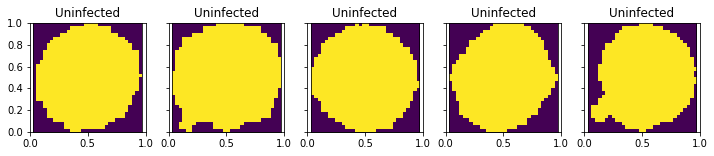

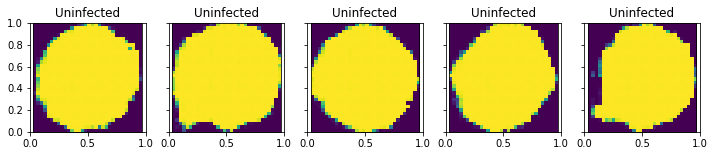

In [13]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
#Sample outputs
output = model(images.float())
loss = criterion(output,images.float())
print(loss.item())

images = images.cpu().numpy()
output = output.view(32, 1, 32, 32)
output = output.detach().cpu().numpy()

def imshow(img):
    plt.imshow(np.squeeze(img)) 

def displaySetImages(imgs, titles):
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,2))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(imgs[idx])
        if titles[idx].numpy() == 0:
            ax.set_title("Uninfected")
        else:
            ax.set_title("Infected")
    plt.show()
    
#Original Images    
displaySetImages(images, labels.cpu())    
#Reconstructed Images
displaySetImages(output, labels.cpu())    

0.6125935316085815


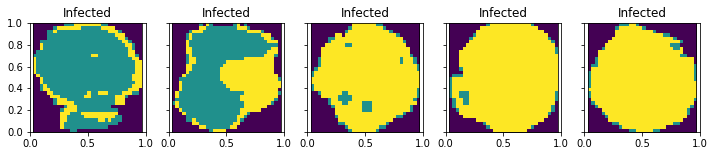

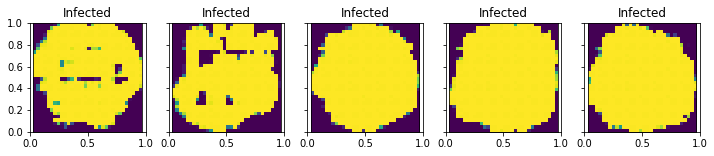

In [14]:
#Batch of test images
dataiter = iter(p_test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
#Sample outputs
output = model(images.float())
loss = criterion(output,images.float())
print(loss.item())

images1 = images.cpu().numpy()
output1 = output.view(32, 1, 32, 32)
output1 = output1.cpu().detach().numpy()

#Original Images
displaySetImages(images1, labels.cpu())    
#Reconstructed Images
displaySetImages(output1, labels.cpu())    

In [15]:
re_test_loader = DataLoader(testset, batch_size=1, shuffle=True)
re_p_test_loader = DataLoader(p_testset, batch_size=1, shuffle=True)

In [16]:
n_PB_loss, p_PB_loss = [],[]
for i,(images,labels) in enumerate(tqdm(re_test_loader)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images.float())
    loss = criterion(outputs,images.float())
    n_PB_loss.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 531.55it/s]


In [17]:
mean = sum(n_PB_loss) / len(n_PB_loss)
variance = sum([((x - mean) ** 2) for x in n_PB_loss]) / len(n_PB_loss)
res = variance ** 0.5

# Printing result
print("Mean of sample is : " + str(mean))
print("Standard deviation of sample is : " + str(res))

Mean of sample is : 0.014918434371087533
Standard deviation of sample is : 0.007767013043922053


In [18]:
for i,(images,labels) in enumerate(tqdm(re_p_test_loader)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images.float())
    loss = criterion(outputs,images.float())

    p_PB_loss.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 605.33it/s]


In [19]:
pmean = sum(p_PB_loss) / len(p_PB_loss)
pvariance = sum([((x - pmean) ** 2) for x in p_PB_loss]) / len(p_PB_loss)
pres = pvariance ** 0.5

# Printing result
print("Mean of sample is : " + str(pmean))
print("Standard deviation of sample is : " + str(pres))

Mean of sample is : 0.6204212079942226
Standard deviation of sample is : 0.21927672461688275


In [20]:
result = np.zeros(len(p_PB_loss))
for i in range(0, len(p_PB_loss)):
    if p_PB_loss[i] > (mean + 2*res):
        result[i] = 1
        
sum(result)/len(p_PB_loss)

1.0

In [21]:
m_loss,y_true = [],[]

for i,(images,labels) in enumerate(tqdm(merged_loader)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images.float())
    loss = criterion(outputs,images.float())

    y_true.append(labels.cpu().numpy())
    m_loss.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████| 4009/4009 [00:06<00:00, 590.19it/s]


In [22]:
result = np.zeros(len(m_loss))
for i in range(0, len(m_loss)):
      if m_loss[i] > (mean + 2*res ):
        result[i] = 1
        
count = 0
for i in range(len(result)):
    if result[i] == y_true[i]:
        count += 1
print(count/len(result))

0.9730606136193565


In [23]:
f_loss,y_true_final = [],[]

for i,(images,labels) in enumerate(tqdm(final_test_loader)):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images.float())
    loss = criterion(outputs,images.float())

    y_true_final.append(labels.cpu().numpy())
    f_loss.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████| 5512/5512 [00:08<00:00, 616.08it/s]


In [24]:
print(sum(y_true_final))

[[2757]]


In [25]:
result = np.zeros(len(f_loss))
for i in range(0, len(f_loss)):
      if f_loss[i] > (mean + 3*res ):
        result[i] = 1
        
count = 0
for i in range(len(result)):
    if result[i] == y_true_final[i]:
        count += 1
print(count/len(result))

0.9816763425253991


In [26]:
new_y_pd = np.array(y_true_final)
new_y_pd.squeeze()

array([0, 0, 1, ..., 1, 0, 1])

In [27]:
ln_p, ln_r, ln_f1, _ = precision_recall_fscore_support(new_y_pd.squeeze(), result, average='binary')
print(ln_p, ln_r, ln_f1)

0.9646606018194541 1.0 0.9820124666073019


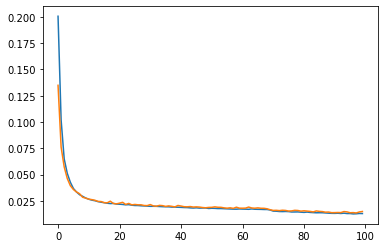

In [28]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

In [29]:
with open('Results/proposed.pkl', 'wb') as f:
    pickle.dump([train_loss,test_loss], f)